In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%%time
%run ../py/sql_utlis.py
su = SqlUtilities()

Wall time: 3 s


In [3]:

%%time
%run ../py/html_analysis.py
hc = HeaderCategories()
ea = ElementAnalysis()
ha = HeaderAnalysis()

Wall time: 44.4 s


In [4]:

import sqlite3
import os

db = sqlite3.connect(os.path.join('../', 'instance', 'flaskr.sqlite'), detect_types=sqlite3.PARSE_DECLTYPES)
db.row_factory = sqlite3.Row


----
## Let's use the child strings data to build a NER system

In [5]:

sql_str = '''
SELECT file_name
FROM "main"."FileNames"
WHERE "file_name_id" IN (
    SELECT file_name_id
    FROM "main"."NavigableParentSequence"
    WHERE "navigable_parent_id" = (
        SELECT navigable_parent_id
        FROM "main"."NavigableParents"
        WHERE "navigable_parent" = '<li>401(k)</li>'
        )
    )'''
cursor_obj = db.execute(sql_str)
row_obj_list = cursor_obj.fetchall()
file_name_list = [row_obj['file_name'] for row_obj in row_obj_list]

In [10]:

import random

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name = random.choice(file_name_list)
while file_name not in HEADER_PATTERN_DICT:
    file_name = random.choice(file_name_list)
feature_dict_list = HEADER_PATTERN_DICT[file_name]
for feature_dict in feature_dict_list:
    if feature_dict['child_str'] == '<li>401(k)</li>':
        break
feature_dict

{'initial_tag': 'li', 'is_header': 0, 'is_task_scope': 0, 'is_req_quals': 0, 'is_preff_quals': 0, 'is_legal_notifs': 0, 'is_job_title': 0, 'is_office_loc': 0, 'is_job_duration': 0, 'is_supp_pay': 1, 'is_educ_reqs': 0, 'is_interv_proc': 0, 'is_corp_scope': 0, 'is_post_date': 0, 'is_other': 0, 'child_str': '<li>401(k)</li>'}

In [ ]:

child_strs_list = ha.get_child_strs_from_file(file_name)
    feature_dict_list = HEADER_PATTERN_DICT[file_name]
    feature_tuple_list = [hc.get_feature_tuple(feature_dict, pos_lr_predict_single=None, pos_crf_predict_single=None) for feature_dict in feature_dict_list]
    prediction_dict_list = []
    for prediction_dict in ea.CRF.predict_marginals_single(ea.sent2features(feature_tuple_list)):
        prediction_dict = {'H': 1 - prediction_dict['O']}
        prediction_dict_list.append(prediction_dict)

In [6]:

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
feature_dict = random.choice(feature_dict_list)
print(feature_dict)
hc.get_feature_tuple(feature_dict, pos_lr_predict_single=None, pos_crf_predict_single=None)

{'initial_tag': 'p', 'is_header': True, 'is_task_scope': False, 'is_req_quals': False, 'is_preff_quals': False, 'is_legal_notifs': False, 'is_job_title': False, 'is_office_loc': True, 'is_job_duration': False, 'is_supp_pay': False, 'is_educ_reqs': False, 'is_interv_proc': False, 'is_corp_scope': False, 'is_post_date': False, 'is_other': False, 'child_str': '<p>Work Remotely:</p>'}


('p', '<p>Work Remotely:</p>', 'H-OL')


## Train an LDA Model to use as one of the features

In [4]:

file_name, child_strs_list = random.choice(list(ea.CHILD_STRS_LIST_DICT.items()))
navigable_parent = random.choice(child_strs_list)
print(navigable_parent)
ea.lda_predict_percent(navigable_parent)

<i>Identify problems and proactively seek solutions with urgency</i>


0.81780326


## Train an Logistic Regression Model to use as one of the features

In [5]:

print(navigable_parent)
ea.lr_predict_percent_is_header(navigable_parent)

<i>Identify problems and proactively seek solutions with urgency</i>


0.08396069036423434


----
## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [11]:

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
sent = [hc.get_feature_tuple(feature_dict, pos_lr_predict_single=None, pos_crf_predict_single=None) for feature_dict in feature_dict_list]
sent

[('div', '<div>At PRA, we don’t make our 17000+ people great. It’s the other way around. As we have grown to a top-5 CRO, we have maintained the feel of a small company, dedicated to collaboration and passion for what we do.</div>', 'O'), ('div', '<div>We always have a desire to keep seeking new and better ways to operate. We don’t settle for the same old ways. Our passion for improving patient lives worldwide permeates all that we do. Put simply, we care.</div>', 'O'), ('b', '<b>Responsibilities</b>', 'H-TS'), ('div', '<div>Due to growth we are currently seeking a Central Data Scientist, to work as part of an established global group that supports project teams in analyzing clinical data to identify risks and data issues, using advanced analytical techniques.</div>', 'O'), ('div', '<div>Acting as a Key Functional Lead on projects; the Central Data Scientist will assess trial compliance, perform trending analysis, exploratory data reviews and report findings to internal and external st

In [14]:

labels_list = ea.sent2labels(sent)
labels_list

['O', 'O', 'H-TS', 'O', 'O', 'H-TS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-RQ', 'H-PQ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-SP', 'O', 'H-O', 'O', 'O', 'O']

In [13]:

ea.sent2features(sent)[1]

{'bias': 1.0, 'child_str.is_header_lr': 0.08548539502940813, 'child_str.lda': 0.9850245, 'position': 2, 'postag': 'O', 'tag.basic_text_set': False, 'tag.block_elements_set': True, 'tag.document_body_elements_set': True, 'tag.inline_elements_set': False, 'tag.lists_set': False, 'tag.null_element': False, 'tag.other_block_elements_set': True, 'tag.phrase_elements_set': False, 'tag.presentation_set': False, 'tag.section_headings_set': False, '-1:postag': 'O', '-1:previous==tag': True, '-1:tag.basic_text_set': False, '-1:tag.block_elements_set': True, '-1:tag.document_body_elements_set': True, '-1:tag.inline_elements_set': False, '-1:tag.lists_set': False, '-1:tag.null_element': False, '-1:tag.other_block_elements_set': True, '-1:tag.phrase_elements_set': False, '-1:tag.presentation_set': False, '-1:tag.section_headings_set': False, '+1:postag': 'H-TS', '+1:tag.basic_text_set': False, '+1:tag.block_elements_set': False, '+1:tag.document_body_elements_set': True, '+1:tag.inline_elements_set

In [8]:

features_dict = random.choice(ea.sent2features(sent))
features_dict

{'bias': 1.0, 'child_str.is_header_lr': 0.08396069036423434, 'child_str.lda': 0.23959309, 'position': 21, 'postag': 'H-RQ', 'tag.basic_text_set': False, 'tag.block_elements_set': False, 'tag.document_body_elements_set': True, 'tag.inline_elements_set': True, 'tag.lists_set': False, 'tag.null_element': False, 'tag.other_block_elements_set': False, 'tag.phrase_elements_set': True, 'tag.presentation_set': True, 'tag.section_headings_set': False, '-1:postag': 'H-RQ', '-1:previous==tag': False, '-1:tag.basic_text_set': False, '-1:tag.block_elements_set': False, '-1:tag.document_body_elements_set': True, '-1:tag.inline_elements_set': True, '-1:tag.lists_set': False, '-1:tag.null_element': False, '-1:tag.other_block_elements_set': False, '-1:tag.phrase_elements_set': True, '-1:tag.presentation_set': True, '-1:tag.section_headings_set': False, '+1:postag': 'O', '+1:tag.basic_text_set': False, '+1:tag.block_elements_set': True, '+1:tag.document_body_elements_set': True, '+1:tag.inline_elements_

In [9]:

%%time
from sklearn.model_selection import train_test_split

all_sents = []
for file_name, feature_dict_list in HEADER_PATTERN_DICT.items():
    feature_dict_list = [hc.get_feature_tuple(feature_dict, pos_lr_predict_single=None, pos_crf_predict_single=None) for feature_dict in feature_dict_list]
    all_sents.append(feature_dict_list)
X = [ea.sent2features(s) for s in all_sents]
y = [ea.sent2labels(s) for s in all_sents]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Wall time: 4.99 s


In [10]:

%%time
ea.CRF.fit(X_train, y_train)
s.store_objects(CRF=ea.CRF)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CRF.pickle
Wall time: 1.07 s


## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [11]:

labels = list(ea.CRF.classes_)
labels.remove('O')
labels

['H-SP', 'H-JD', 'H-RQ', 'H-OL', 'H-IP', 'H-TS', 'H-ER', 'H-O', 'H-PQ', 'H-CS', 'H-LN', 'H-PD']

In [12]:

from sklearn_crfsuite import metrics

y_pred = ea.CRF.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9075845410628018

In [13]:

print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

              precision    recall  f1-score   support

        H-SP      1.000     1.000     1.000         3
        H-JD      0.875     1.000     0.933         7
        H-RQ      1.000     1.000     1.000        16
        H-OL      0.875     1.000     0.933         7
        H-IP      0.000     0.000     0.000         2
        H-TS      0.917     1.000     0.957        11
        H-ER      1.000     1.000     1.000         3
         H-O      0.000     0.000     0.000         0
        H-PQ      1.000     1.000     1.000         2
        H-CS      1.000     1.000     1.000         5
        H-LN      0.500     0.333     0.400         3
        H-PD      0.500     1.000     0.667         1

   micro avg      0.903     0.933     0.918        60
   macro avg      0.722     0.778     0.741        60
weighted avg      0.889     0.933     0.908        60



C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['H-SP', 'H-JD', 'H-RQ', 'H-OL', 'H-IP', 'H-TS', 'H-ER', 'H-O', 'H-PQ', 'H-CS', 'H-LN', 'H-PD'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:

file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
feature_tuple_list = [hc.get_feature_tuple(feature_dict, pos_lr_predict_single=None, pos_crf_predict_single=None) for feature_dict in feature_dict_list]
prediction_dict_list = ea.CRF.predict_marginals_single(ea.sent2features(feature_tuple_list))
random.choice(prediction_dict_list)

{'O': 0.9981307112857007, 'H-SP': 0.00013195185933857827, 'H-JD': 0.00010296985571215306, 'H-RQ': 0.00014179349785178744, 'H-OL': 0.00018050946954418107, 'H-IP': 0.0005246248855400224, 'H-TS': 0.00013339230492390787, 'H-ER': 0.0002445399465849695, 'H-O': 0.0001748253536049885, 'H-PQ': 6.110183971685273e-05, 'H-CS': 9.392808218384382e-05, 'H-LN': 6.984589507699336e-05, 'H-PD': 9.805724222426692e-06}

In [ ]:

ea.sent2features(feature_tuple_list)

In [18]:

prediction_dict_list[1]

{'O': 0.9979962726263131, 'H-SP': 0.00013238391155190942, 'H-JD': 0.00013721274801617838, 'H-RQ': 0.000393209425499541, 'H-OL': 6.052471491135669e-05, 'H-IP': 0.0003479614911953031, 'H-TS': 0.00021110685569905436, 'H-ER': 0.0001470471324799412, 'H-O': 0.0002677782476612798, 'H-PQ': 0.00016888650608329952, 'H-CS': 9.538167753504436e-05, 'H-LN': 2.0387432842116295e-05, 'H-PD': 2.1847230212869417e-05}


----
## Make a Prediction Visualization

In [15]:

def plot_child_str_predictions(file_name, ax=None):
    child_strs_list = ha.get_child_strs_from_file(file_name)
    HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
    if file_name in HEADER_PATTERN_DICT:
        feature_dict_list = HEADER_PATTERN_DICT[file_name]
        feature_tuple_list = [hc.get_feature_tuple(feature_dict, pos_lr_predict_single=None, pos_crf_predict_single=None) for feature_dict in feature_dict_list]
        prediction_dict_list = []
        for prediction_dict in ea.CRF.predict_marginals_single(ea.sent2features(feature_tuple_list)):
            prediction_dict = {'H': 1 - prediction_dict['O']}
            prediction_dict_list.append(prediction_dict)
    else:
        prediction_dict_list = []
        for child_str in child_strs_list:
            if(CLF_NAME == 'LdaModel'):
                H = ea.lda_predict_percent_is_header(child_str)
            else:
                H = ea.lr_predict_percent_is_header(child_str)
            prediction_dict = {'H': H}
            prediction_dict_list.append(prediction_dict)
    rows_list = []
    for child_str, marginals_dict in zip(child_strs_list, prediction_dict_list):
        row_dict = {'probability': marginals_dict['H']}
        if child_str in ha.NAVIGABLE_PARENT_IS_HEADER_DICT:
            row_dict['actual'] = ha.NAVIGABLE_PARENT_IS_HEADER_DICT[child_str] * 1.0
        else:
            row_dict['actual'] = np.nan
        rows_list.append(row_dict)
    df = pd.DataFrame(rows_list)
    coor = round(df.corr().loc['probability', 'actual'], 4)
    if (coor < 0.999) or (ax is not None):
        if ax is None:
            fig = plt.figure(figsize=(18, 2.5))
            ax = fig.add_subplot(1, 1, 1)
            title_text = fig.suptitle(t=f'Correlation to Actual: {coor}', y=1.55)
        AxesSubplot_obj = df.plot.line(ax=ax)
        ax.axis('off')
        for x, child_str in enumerate(child_strs_list):
            y = rows_list[x]['probability']
            if str(y) == 'nan':
                y = rows_list[x]['actual']
            if str(y) != 'nan':
                ax.annotate(f'{child_str[:20]}...', (x, y), ha='left', rotation=90)

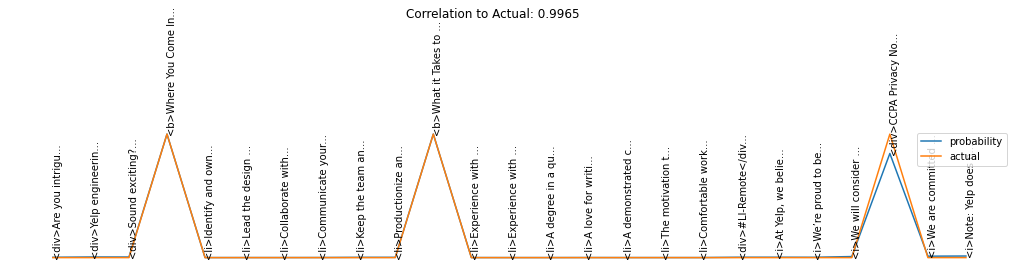

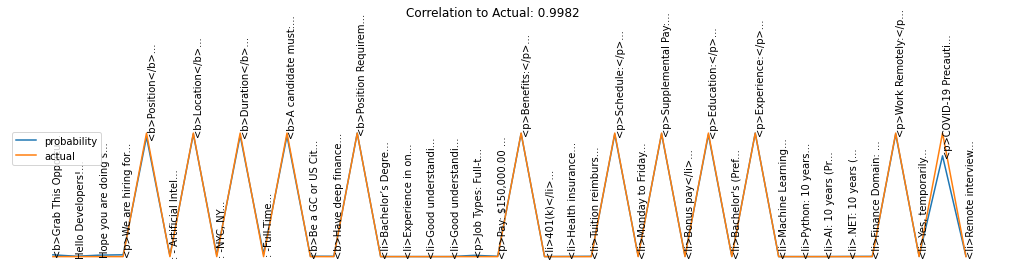

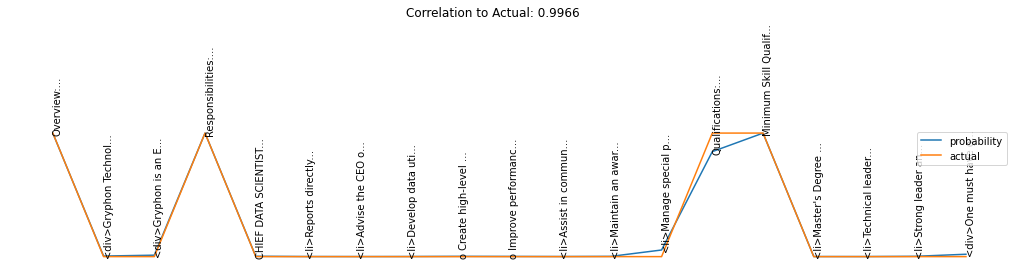

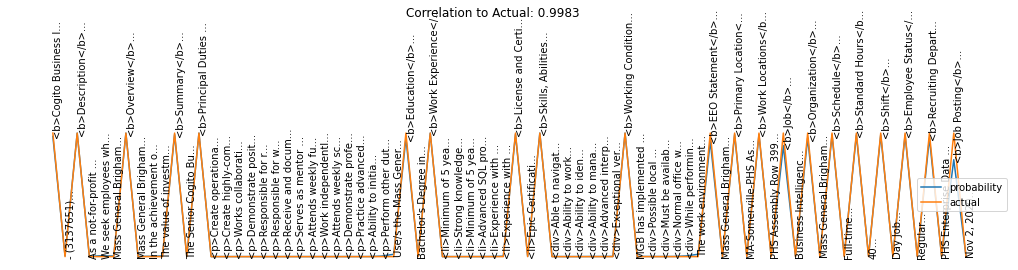

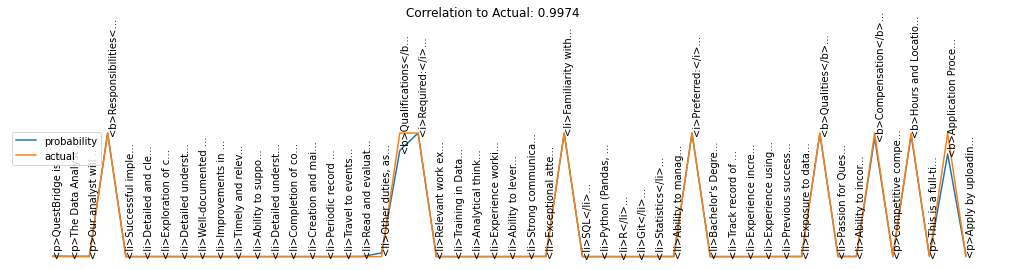

In [16]:

for file_name in list(HEADER_PATTERN_DICT.keys()):
    plot_child_str_predictions(file_name)


----
# Find the Basic Qualifications Section

In [23]:

def find_basic_quals_section(file_name):
    child_strs_list = ha.get_child_strs_from_file(file_name)
    child_tags_list = ha.get_child_tags_list(child_strs_list)
    is_header_list = ha.get_is_header_list(child_strs_list)
    feature_dict_list = hc.get_feature_dict_list(child_tags_list, is_header_list, child_strs_list)
    feature_tuple_list = [hc.get_feature_tuple(feature_dict, pos_lr_predict_single=None, pos_crf_predict_single=None) for feature_dict in feature_dict_list]
    crf_list = ea.CRF.predict_single(ea.sent2features(feature_tuple_list))
    pos_list = []
    for pos, feature_tuple in zip(crf_list, feature_tuple_list):
        navigable_parent = feature_tuple[1]
        if navigable_parent in ha.NAVIGABLE_PARENT_IS_HEADER_DICT:
            pos_list = hc.append_parts_of_speech_list(navigable_parent, pos_list)
        else:
            pos_list.append(pos)
    consecutives_list = []
    for k, v in groupby(pos_list):
        consecutives_count = len(list(v))
        consecutives_tuple = (pos, consecutives_count)
        consecutives_list.append(consecutives_tuple)
    
    return consecutives_list, pos_list, feature_tuple_list, child_strs_list

In [28]:

from itertools import groupby

files_list = os.listdir(ha.SAVES_HTML_FOLDER)
file_name = random.choice(files_list)
while file_name in HEADER_PATTERN_DICT:
    file_name = random.choice(files_list)
consecutives_list, pos_list, feature_tuple_list, child_strs_list = find_basic_quals_section(file_name)
print(consecutives_list)
print(pos_list)
print(child_strs_list)

[('O', 1), ('O', 2), ('O', 1), ('O', 12), ('O', 1), ('O', 15)]
['H-TS', 'O', 'O', 'H-TS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-CS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['<b>The Role:</b>', "<p>As the Director of Data Science at Brightloom, you'll lead the data science team and partner across the organization to help grow our data science capabilities. You'll be taking business needs from product and engineering teams and creating a comprehensive data science strategy around them. From there, you help prioritize the work for the data science team, balancing the work for the team and helping the independent contributors be their best. You will heavily engage with the application engineering, data engineering, and data science technical leads to ensure that your data science strategies are operationalized effectively.</p>", "<p>You're a person who loves helping others work together to do interesting data science. You can eva

In [26]:

from itertools import groupby

files_list = os.listdir(ha.SAVES_HTML_FOLDER)
file_name = random.choice(files_list)
while file_name in HEADER_PATTERN_DICT:
    file_name = random.choice(files_list)
consecutives_list, pos_list, feature_tuple_list, child_strs_list = find_basic_quals_section(file_name)
print(consecutives_list)
print(pos_list)
ea.display_basic_requirements(child_strs_list)

[('O', 1), ('O', 14)]
['H-TS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [20]:

for pos_tuple in [(hc.POS_EXPLANATION_DICT[pos],
                   feature_tuple[1] if pos != 'O' else f'{feature_tuple[1][:50]}...') for pos, feature_tuple in zip(pos_list, feature_tuple_list)]:
    print(pos_tuple)

('Task Scope Header', '<h2 class="jobsearch-JobDescriptionSection-jobDescriptionTitle icl-u-xs-my--md" id="jobDescriptionTitle">Full Job Description</h2>')
('Non-header', '<b>Marketing Data Scientist</b>...')
('Non-header', '<b>Reports To:</b>...')
('Non-header', 'SVP, Marketing...')
('Job Duration Header', '<b>Job Location:</b>')
('Non-header', 'Ewing, NJ / Remote...')
('Job Duration Header', '<b>Desired Start Date</b>')
('Non-header', ': Immediate...')
('Education Requirements Header', '<b>Compensation</b>')
('Non-header', ': $60-100K depending on experience...')
('Corporate Scope Header', '<b>Overview:</b>')
('Non-header', 'Is this a place you’d like to work? We’re a team o...')
('Non-header', '<p>Princeton Mortgage seeks to hire a Data Scienti...')
('Task Scope Header', '<b>Responsibilities:</b>')
('Non-header', '<li>Work with stakeholders throughout the organiza...')
('Non-header', '<li>Mine and analyze data from company databases t...')
('Non-header', '<li>Assess the effectivenes

In [24]:

rows_list = [{'navigable_parent': navigable_parent,
              'is_header': is_header} for navigable_parent, is_header in ha.NAVIGABLE_PARENT_IS_HEADER_DICT.items()]
child_str_df = pd.DataFrame(rows_list)
s.store_objects(child_str_df=child_str_df)
child_str_df = s.load_object('child_str_df')
child_str_df[child_str_df.is_header].navigable_parent.tolist()

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\child_str_df.pickle


['<b>Where You Come In:</b>', '<b>What it Takes to Succeed:</b>', '<div>CCPA Privacy Notice</div>', '<b>Position</b>', '<b>Location</b>', '<b>Duration</b>', '<b>A candidate must:</b>', '<b>Position Requirements:</b>', '<p>Schedule:</p>', '<p>Supplemental Pay:</p>', '<p>Education:</p>', '<p>Experience:</p>', '<p>Work Remotely:</p>', '<p>COVID-19 Precaution(s):</p>', '<p>Work Location:</p>', '<b>Responsibilities:</b>', '<b>Qualifications:</b>', '<b>Primary Responsibilities:</b>', '<b>Required Qualifications:</b>', '<b>Preferred Qualifications:</b>', '<b>Careers with Optum.</b>', '<h2 class="jobsearch-JobDescriptionSection-jobDescriptionTitle icl-u-xs-my--md" id="jobDescriptionTitle">Full Job Description</h2>', '<b>What will you do?</b>', '<b>What does your success look like in the first 90 days?</b>', '<b>What are we looking for?</b>', '<b>What skills, experiences, and education are required?</b>', '<b>Why LPL?</b>', '<b>Information on Interviews:</b>', '<b>Location and Travel:</b>', '<b


----

In [25]:

from pycrfsuite import ItemSequence

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
#sequence_obj_dict = {file_name: ItemSequence(feature_dict_list) for file_name, feature_dict_list in HEADER_PATTERN_DICT.items()}
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
sequence_obj = ItemSequence(feature_dict_list)
random.choice(sequence_obj.items())

{'initial_tag:li': 1.0, 'is_header': 0.0, 'is_task_scope': 0.0, 'is_req_quals': 0.0, 'is_preff_quals': 0.0, 'is_legal_notifs': 0.0, 'is_job_title': 0.0, 'is_office_loc': 0.0, 'is_job_duration': 0.0, 'is_supp_pay': 0.0, 'is_educ_reqs': 0.0, 'is_interv_proc': 0.0, 'is_corp_scope': 0.0, 'is_post_date': 0.0, 'is_other': 0.0, 'child_str:<li>Experience with data analysis/statistical software and packages (pandas/statsmodels/sklearn within Python, R, etc.)</li>': 1.0}


----
# Create the Header Pattern Dictionary

In [9]:

%%time
%run ../py/html_analysis.py
ha = HeaderAnalysis()
ea = ElementAnalysis()
%run ../py/sql_utlis.py
su = SqlUtilities()
import sqlite3
import os
db = sqlite3.connect(os.path.join('../', 'instance', 'flaskr.sqlite'), detect_types=sqlite3.PARSE_DECLTYPES)
db.row_factory = sqlite3.Row
files_list = os.listdir(ha.SAVES_HTML_FOLDER)
HEADER_PATTERN_DICT = {}
for file_name in files_list:
    if file_name in ea.CHILD_STRS_LIST_DICT:
        child_strs_list = ea.CHILD_STRS_LIST_DICT[file_name]
    else:
        file_path = os.path.join(ha.SAVES_HTML_FOLDER, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_str = f.read()
            body_soup = ha.get_body_soup(html_str)
            child_strs_list = ha.get_navigable_children(body_soup, [])
    if not len(child_strs_list):
            file_path = os.path.join(ha.SAVES_HTML_FOLDER, file_name)
            os.remove(file_path)
            continue
    navigable_parent = child_strs_list[0]
    child_tags_list = []
    for navigable_parent in child_strs_list:
        tokenized_sent = ha.html_regex_tokenizer(navigable_parent)
        try:
            first_token = tokenized_sent[0]
            if first_token[0] == '<':
                child_tags_list.append(first_token[1:])
            else:
                child_tags_list.append('plaintext')
        except:
            child_tags_list.append('plaintext')
    if len(child_tags_list) == len(child_strs_list):
        if file_name not in ea.CHILD_STRS_LIST_DICT:
            ea.CHILD_STRS_LIST_DICT[file_name] = child_strs_list
            s.store_objects(CHILD_STRS_LIST_DICT=ea.CHILD_STRS_LIST_DICT)
        if file_name not in HEADER_PATTERN_DICT:
            item_sequence = su.get_feature_dict_list(db, child_tags_list, child_strs_list)
            HEADER_PATTERN_DICT[file_name] = item_sequence
            s.store_objects(HEADER_PATTERN_DICT=HEADER_PATTERN_DICT)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Wall time: 5min 52s


In [ ]:

text_editor_path = r'C:\Program Files\Notepad++\notepad++.exe'
file_path = os.path.join(ha.SAVES_HTML_FOLDER, file_name)
!"{text_editor_path}" "{os.path.abspath(file_path)}"

In [6]:

import sys

command_str = f'{sys.executable} -m pip install --upgrade sklearn-crfsuite'
print(command_str)
!{command_str}

C:\Users\dev\Documents\Repositories\job-hunting\jh\python.exe -m pip install --upgrade sklearn-crfsuite
  Using cached sklearn_crfsuite-0.3.6-py2.py3-none-any.whl (12 kB)
  Using cached tabulate-0.8.7-py3-none-any.whl (24 kB)
  Using cached tqdm-4.54.1-py2.py3-none-any.whl (69 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
